# Path to Zenodo files folder

In [1]:
path = 'PATH/TO/ZENODO/FILES/FOLDER'

# Figure S10

## Panel a

In [2]:
import pandas as pd
weights_2ndor_spreg = pd.read_csv(path+'Fig6/FYN_suppressor_mochi_order2_sparse_regularized/task_4/weights/weights_Folding.txt', sep='\t')

weights_2ndor_spreg.rename(columns={'mean_kcal/mol':'mean_kcal_mol', 'std_kcal/mol':'std_kcal_mol', 'ci95_kcal/mol':'ci95_kcal_mol'}, inplace=True)
for index, row in weights_2ndor_spreg.iterrows():
    if row.id_ref == 'WT':
        weights_2ndor_spreg.at[index,'order']=0
    else:
        weights_2ndor_spreg.at[index,'order']=len(row.id.split('_'))


In [3]:
secondorderterms=weights_2ndor_spreg.loc[weights_2ndor_spreg['order']==2].copy()

secondorderterms['mutation1']='a'
secondorderterms['mutation2']='a'
for index,row in secondorderterms.iterrows():
    secondorderterms.at[index,'mutation1']=row.id.split('_')[0]
    secondorderterms.at[index,'mutation2']=row.id.split('_')[1]

single_mutations=[]
for index, row in secondorderterms.iterrows():
    if row.mutation1 not in single_mutations:
        single_mutations.append(row.mutation1)
for index, row in secondorderterms.iterrows():
    if row.mutation2 not in single_mutations:
        single_mutations.append(row.mutation2)    
single_mutations=sorted(single_mutations, key=lambda x: (int(x[1:-1]), x[-1]) )

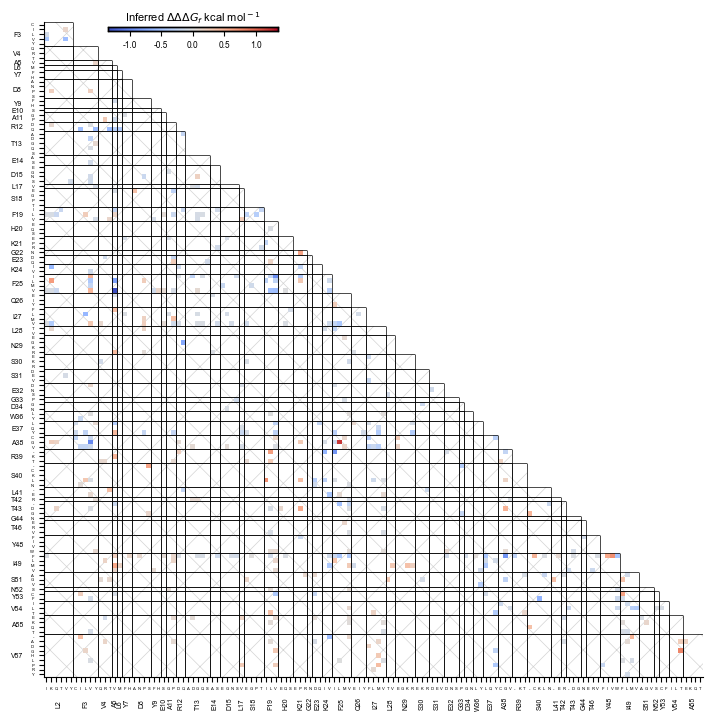

In [4]:
from matplotlib.patches import Rectangle
from matplotlib.patches import PathPatch
from matplotlib.path import Path
import seaborn as sns
import matplotlib.pyplot as plt
import math
from collections import Counter
import matplotlib as mpl
import numpy as np

plt.rcParams['font.family'] = 'Arial'

pairwise_secondorderterms=pd.DataFrame(columns=single_mutations)

for index, row in secondorderterms.iterrows():
    pairwise_secondorderterms.at[row.mutation1,row.mutation2]=row.mean_kcal_mol

for index, row in secondorderterms.iterrows():
    pairwise_secondorderterms.at[row.mutation2,row.mutation1]=row.mean_kcal_mol

pairwise_secondorderterms=pairwise_secondorderterms.fillna(np.nan)
pairwise_secondorderterms=pairwise_secondorderterms.reindex(single_mutations)

#plt.figure(figsize=(10,8))
fig, ax=plt.subplots(figsize=(8.5,8.5))


mask = np.zeros_like(pairwise_secondorderterms.iloc[list(Counter([i[:-1] for i in single_mutations]).values())[0]:,:-1*list(Counter([i[:-1] for i in single_mutations]).values())[-1]], dtype=bool)

rowiterator=0
columniterator=0
for index, row in pairwise_secondorderterms.iloc[list(Counter([i[:-1] for i in single_mutations]).values())[0]:,:-1*list(Counter([i[:-1] for i in single_mutations]).values())[-1]].iterrows():
    for column in pairwise_secondorderterms.iloc[list(Counter([i[:-1] for i in single_mutations]).values())[0]:,:-1*list(Counter([i[:-1] for i in single_mutations]).values())[-1]].columns:
        if int(row.name[1:-1]) <= int(column[1:-1]):
            mask[rowiterator, columniterator]=True
            columniterator+=1
        else:
            mask[rowiterator, columniterator]=False
            columniterator+=1
    columniterator=0
    rowiterator+=1
    
mask



            
cbar_ax=fig.add_axes([0.2,0.87,0.2,0.005])

mpl.rcParams['hatch.linewidth'] = 0.5
ax.patch.set(hatch='x', edgecolor='#D3D3D3')
ax.patch.set_linewidth(0)
ax.set_facecolor('white')
couplings_boundary=abs(pairwise_secondorderterms).fillna(0).to_numpy().max()
hmap=sns.heatmap(pairwise_secondorderterms.iloc[list(Counter([i[:-1] for i in single_mutations]).values())[0]:,:-1*list(Counter([i[:-1] for i in single_mutations]).values())[-1]], cmap='coolwarm', center=0, xticklabels=True,yticklabels=True, mask=mask,vmin=-1*couplings_boundary, vmax=couplings_boundary,
              cbar_kws={"orientation": "horizontal", "pad": 0.02, 'ticks':list(np.arange(-2,3,1))}, ax=ax, cbar_ax=cbar_ax, fmt= '', annot_kws={'size':4})


#ax.figure.axes[-1].set_ylabel('ddG', rotation=270)
cbar_ax.set_xlabel(r'Inferred ${ΔΔΔG_{f}}$ kcal mol$^-$$^1$', rotation=0, fontsize=8)
cbar_ax.xaxis.set_label_position('top')
cbar_ax.set_xticks(np.arange(-1,1.2,0.5), [str(round(i,1)) for i in np.arange(-1,1.2,0.5)], fontsize=6)
for spine in cbar_ax.spines.values():
    spine.set(visible=True,lw=1,edgecolor='black')

    
labels_x = [item.get_text() for item in ax.get_xticklabels()]
for label_nr, label in enumerate(labels_x):
    labels_x[label_nr]=label[-1]
ax.set_xticklabels(labels_x, rotation=0,fontsize=3)
labels_y = [item.get_text() for item in ax.get_yticklabels()]
for label_nr, label in enumerate(labels_y):
    labels_y[label_nr]=label[-1]
ax.set_yticklabels(labels_y, rotation=0,fontsize=3)


start_row=0
start_col=0

codes= [Path.MOVETO, Path.LINETO]
for rows in enumerate(list(Counter([i[:-1] for i in single_mutations]).values())[1:]):
    for cols in enumerate(list(Counter([i[:-1] for i in single_mutations]).values())[:]):
        if rows[0]<cols[0]:
            rect = Rectangle((start_col, start_row), cols[1], rows[1], linewidth=0,facecolor='white')
            ax.add_patch(rect)
            if cols[0]-rows[0]==1:
                rx, ry = rect.get_xy()
                cx = rx + rect.get_width()
                cy = ry + rect.get_height()
                vertices=[(rx,ry), (rx, cy)]
                pth= Path(vertices, codes)
                line_patch = PathPatch(pth, lw=0.5, color='k')
                ax.add_patch(line_patch)
        else:
            rect = Rectangle((start_col, start_row), cols[1], rows[1], linewidth=0.5, edgecolor='black',facecolor='none')
            ax.add_patch(rect)
            
            rx, ry = rect.get_xy()
            cx = rx + rect.get_width()/2
            cy = ry + rect.get_height()/2
            if start_col == 0:
                ax.annotate(list(Counter([i[:-1] for i in single_mutations]).keys())[1:][rows[0]], (cx-8.5,cy), ha= 'center', va='center',fontsize=5, annotation_clip=False)
            if start_row == (sum(list(Counter([i[:-1] for i in single_mutations]).values())[1:])-rows[1]):
                ax.annotate(list(Counter([i[:-1] for i in single_mutations]).keys())[:][cols[0]], (cx,cy+10), ha= 'center', va='center',fontsize=5, annotation_clip=False, rotation=90)
        
            
        start_col=start_col+cols[1]
        
    start_col=0
    start_row=start_row+rows[1]

ax.spines[['left','bottom']].set_visible(True)
ax.spines[['top','right']].set_visible(False)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('Suppressor_2ndordersprsreg_2ndorderterms.png', dpi=300, bbox_inches = "tight")

## Panel b

### Core mutagenesis 2nd order energy model

In [5]:
import pandas as pd
weights_core_mut = pd.read_csv(path+'Fig3/FYN-SH3/FYN_mochi_order2/task_1/weights/weights_Folding.txt', sep='\t')

weights_core_mut.rename(columns={'mean_kcal/mol':'core_mut_mean_kcal_mol', 'std_kcal/mol':'core_mut_std_kcal_mol', 'ci95_kcal/mol':'core_mut_ci95_kcal_mol'}, inplace=True)
for index, row in weights_core_mut.iterrows():
    weights_core_mut.at[index,'order']=len(row.id.split('_'))

weights_merger = weights_core_mut[['id','core_mut_mean_kcal_mol','core_mut_std_kcal_mol','core_mut_ci95_kcal_mol','order']].merge(weights_2ndor_spreg[['id','mean_kcal_mol','std_kcal_mol','ci95_kcal_mol']], left_on='id',right_on='id')


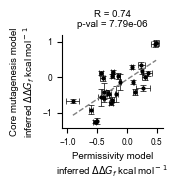

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

df = weights_merger.sort_values('mean_kcal_mol').copy()

g = sns.FacetGrid(data=df.loc[df['order']==2], aspect=2)
g.map(plt.errorbar, 'mean_kcal_mol', 'core_mut_mean_kcal_mol', 'core_mut_std_kcal_mol','std_kcal_mol', fmt='o', elinewidth=0.5, capsize=2, capthick=0.5, markersize=2, color='k')
#g.add_legend(bbox_to_anchor=(1.3,0.7), title='', fontsize=6)
g.fig.set_size_inches(1.2,1.2)
g.tick_params(axis='both', which='major', labelsize=6)

x = df.loc[df['order']==2][['mean_kcal_mol']].to_numpy()
y = df.loc[df['order']==2][['core_mut_mean_kcal_mol']].to_numpy()


model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)
r2 = r2_score(y,y_pred)
r,p = pearsonr(y.ravel(),x.ravel())

plt.plot(x, y_pred, color='Gray', linewidth=1, linestyle='--')
plt.xlabel('Permissivity model\n'+r'inferred ${ΔΔG_{f}}$ kcal mol$^-$$^1$', fontsize=7)
plt.ylabel('Core mutagenesis model\n'+r'inferred ${ΔΔG_{f}}$ kcal mol$^-$$^1$', fontsize=7)
plt.title('R = '+str(round(r,2))+'\np-val = {:0.2e}'.format(p), fontsize=7, color='k')

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('Permi_vs_2ndordercore_model_2ndorderterms.svg', dpi=300, transparent=True)

### Core mutagenesis 2nd order sparse regularized energy model

In [7]:
import pandas as pd
weights_core_mut = pd.read_csv(path+'Fig3/FYN-SH3/FYN_mochi_order2_sparse_regularized/task_4/weights/weights_Folding.txt', sep='\t')

weights_core_mut.rename(columns={'mean_kcal/mol':'core_mut_mean_kcal_mol', 'std_kcal/mol':'core_mut_std_kcal_mol', 'ci95_kcal/mol':'core_mut_ci95_kcal_mol'}, inplace=True)
for index, row in weights_core_mut.iterrows():
    weights_core_mut.at[index,'order']=len(row.id.split('_'))

weights_merger = weights_core_mut[['id','core_mut_mean_kcal_mol','core_mut_std_kcal_mol','core_mut_ci95_kcal_mol','order']].merge(weights_2ndor_spreg[['id','mean_kcal_mol','std_kcal_mol','ci95_kcal_mol']], left_on='id',right_on='id')


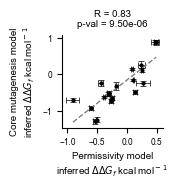

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

df = weights_merger.sort_values('mean_kcal_mol').copy()

g = sns.FacetGrid(data=df.loc[df['order']==2], aspect=2)
g.map(plt.errorbar, 'mean_kcal_mol', 'core_mut_mean_kcal_mol', 'core_mut_std_kcal_mol','std_kcal_mol', fmt='o', elinewidth=0.5, capsize=2, capthick=0.5, markersize=2, color='k')
#g.add_legend(bbox_to_anchor=(1.3,0.7), title='', fontsize=6)
g.fig.set_size_inches(1.2,1.2)
g.tick_params(axis='both', which='major', labelsize=6)

x = df.loc[df['order']==2][['mean_kcal_mol']].to_numpy()
y = df.loc[df['order']==2][['core_mut_mean_kcal_mol']].to_numpy()


model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)
r2 = r2_score(y,y_pred)
r,p = pearsonr(y.ravel(),x.ravel())

plt.plot(x, y_pred, color='Gray', linewidth=1, linestyle='--')
plt.xlabel('Permissivity model\n'+r'inferred ${ΔΔG_{f}}$ kcal mol$^-$$^1$', fontsize=7)
plt.ylabel('Core mutagenesis model\n'+r'inferred ${ΔΔG_{f}}$ kcal mol$^-$$^1$', fontsize=7)
plt.title('R = '+str(round(r,2))+'\np-val = {:0.2e}'.format(p), fontsize=7, color='k')

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('Permi_vs_2ndordersprsregcore_model_2ndorderterms.svg', dpi=300, transparent=True)

## Panel c

/var/folders/32/dtq6y36s6mjg1zcf2_9dskdm0000gn/T/ipykernel_98327/872578628.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(width/6,0.2))


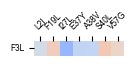

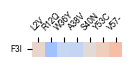

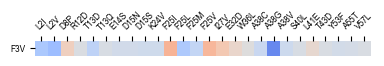

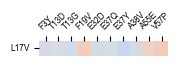

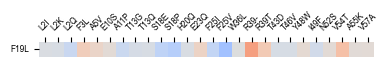

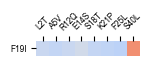

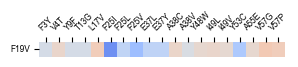

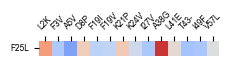

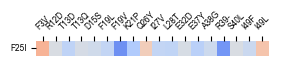

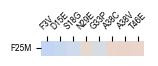

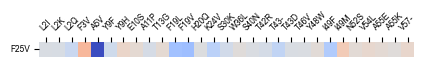

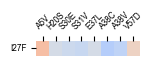

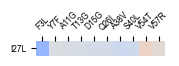

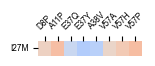

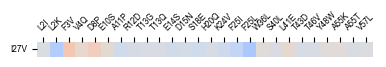

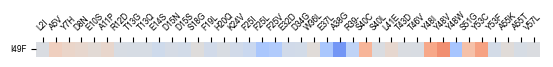

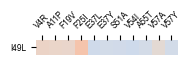

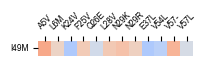

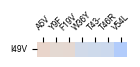

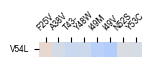

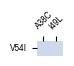

In [9]:
DTS=['F','L','I','M','V']
fyn_core_pos = [2,16,18,24,26,48,53]
fyn_wt_core = 'FLFFIIV'

fyn_core_singles=[]
for wt_res, pos in zip(fyn_wt_core,fyn_core_pos):
    for mut_to in DTS:
        if wt_res != mut_to:
            fyn_core_singles.append(wt_res+str(pos+1)+mut_to)
for single_core_mutation in fyn_core_singles:
    try:
        width=len(pairwise_secondorderterms.loc[pairwise_secondorderterms[single_core_mutation].notnull()][[single_core_mutation]].T.columns)
        plt.figure(figsize=(width/6,0.2))
        ax=sns.heatmap(pairwise_secondorderterms.loc[pairwise_secondorderterms[single_core_mutation].notnull()][[single_core_mutation]].T, cmap='coolwarm', center=0, xticklabels=True,yticklabels=True,cbar=False,cbar_kws={"orientation": "horizontal", "pad": 0.02, 'location':'bottom'},
                      vmax=abs(pairwise_secondorderterms).fillna(0).to_numpy().max(), vmin=-1*abs(pairwise_secondorderterms).fillna(0).to_numpy().max())
        ax.xaxis.set_label_position('top')
        plt.yticks(fontsize=6, rotation=0)
        plt.tick_params(axis='both', which='both', labelbottom=False, bottom=False, top=True, labeltop=True)
        plt.xticks(rotation=45,fontsize=6)
        plt.rcParams['svg.fonttype'] = 'none'
        #plt.savefig('Suppressor_2ndordersprsreg_2ndorderterms'+pairwise_secondorderterms.loc[pairwise_secondorderterms[single_core_mutation].notnull()][[single_core_mutation]].T.index[0]+'.svg', dpi=300, bbox_inches = "tight")
    except:
        continue